In [1]:
#https://docs.ray.io/en/latest/serve/tutorials/pytorch.html

In [2]:
import os 
import time
import requests
from io import BytesIO
from PIL import Image

import ray
from ray import serve

import torch
import torchvision
from torchvision.transforms import ToTensor, Resize,Compose, ToPILImage

In [3]:
@serve.deployment(route_prefix="/image_predict")
class ImageModel:
    
    def __init__(self):
        self.model = torch.jit.load("ray_model_scripted.pt", 
                                    map_location=torch.device('cpu'))
        self.preprocessor = Compose([Resize((64,64)),
                                     ToTensor()])
        
        
    async def __call__(self, starlette_request):
        image_payload_bytes = await starlette_request.body()
        pil_image = Image.open(BytesIO(image_payload_bytes))
        
        pil_images = [pil_image]
        input_tensor = torch.cat([self.preprocessor(i) for i in pil_images])
        input_tensor = torch.reshape(input_tensor, (1,3,64,64))
        
        with torch.no_grad():
            output_tensor = self.model(input_tensor)
            
        return int(torch.argmax(output_tensor[0]))

In [ ]:
ray.init('ray://{ray_head}:10001'.format(ray_head=os.environ['RAY_CLUSTER']),
         runtime_env={"working_dir": "models/"})

In [5]:
host = ray.nodes()[0]["NodeManagerAddress"]

In [ ]:
serve.start(http_options={"host":host})

In [7]:
ImageModel.deploy()

(HTTPProxyActor pid=2344) INFO:     Started server process [2344]
(ServeController pid=2309) INFO 2022-08-17 20:33:46,624 controller 2309 deployment_state.py:1216 - Adding 1 replicas to deployment 'ImageModel'.


In [8]:
with open("data/oxford-iiit-pet/images/Abyssinian_22.jpg", "rb") as image:
    f = image.read()
    b = bytearray(f)

In [9]:
resp = requests.post(f"http://{host}:8000/image_predict", data=b)

In [10]:
print(f"Predicted Class: {resp.json()}")

Predicted Class: 20


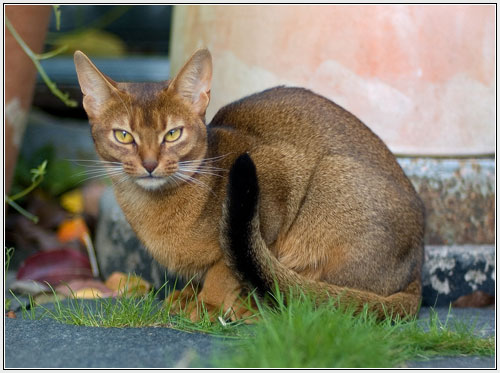

In [12]:
Image.open(BytesIO(b))